# HTGR Micro-Core Quadrant Power

**Input**

- `theta1`: Angle of control drum in quadrant 1 (radians) 
- `theta2`: Angle of control drum in quadrant 1 (radians) 
- `theta3`: Angle of control drum in quadrant 2 (radians)  
- `theta4`: Angle of control drum in quadrant 2 (radians)
- `theta5`: Angle of control drum in quadrant 3 (radians)
- `theta6`: Angle of control drum in quadrant 3 (radians)
- `theta7`: Angle of control drum in quadrant 4 (radians)  
- `theta8`: Angle of control drum in quadrant 4 (radians)  

**Output** 

- `fluxQ1` : Neutron flux in quadrant 1 ($\frac{neutrons}{cm^{2} s}$)
- `fluxQ2` : Neutron flux in quadrant 2 ($\frac{neutrons}{cm^{2} s}$)
- `fluxQ3` : Neutron flux in quadrant 3 ($\frac{neutrons}{cm^{2} s}$)
- `fluxQ4` : Neutron flux in quadrant 4 ($\frac{neutrons}{cm^{2} s}$)

The `pyMAISE.datasets.load_HTGR` data features 751 samples with eight inputs and five outputs. It is the raw data from [[PRK22]](https://pymaise.readthedocs.io/en/stable/index.html#id9). Using reactor symmetry, [[PRK22]](https://pymaise.readthedocs.io/en/stable/index.html#id9) boosts the sample size to 3004. 

The data set was built using MCNP simulations of the HOLOS-Quad reactor design, which is depicted below [[PRK22]](https://pymaise.readthedocs.io/en/stable/index.html#id9). This reactor implements modular construction where separate units can be transported independently and assembled at the plant. The HOLOS-Quad core is a 22 MWt high-temperature gas-cooled microreactor (HTGR) controlled by eight cylindrical control drums. It utilizes TRISO fuel particles contained in hexagonal graphite blocks as a moderator. These graphite blocks have channels where helium gas can pass through for cooling.

Using machine learning (ML), we aim to predict the neutron distribution given the angles of each of the control drums $\in[0, 2\pi]$. The drums control reactivity by rotating to vary the proximity of $B_4C$, indicated as the red strip on the drums shown below, to the fuel. Perturbations in the control drum angle can drastically affect the power distribution in the core. Therefore, predictions of control drum reactivity worth for arbitrary configurations make this problem nontrivial.

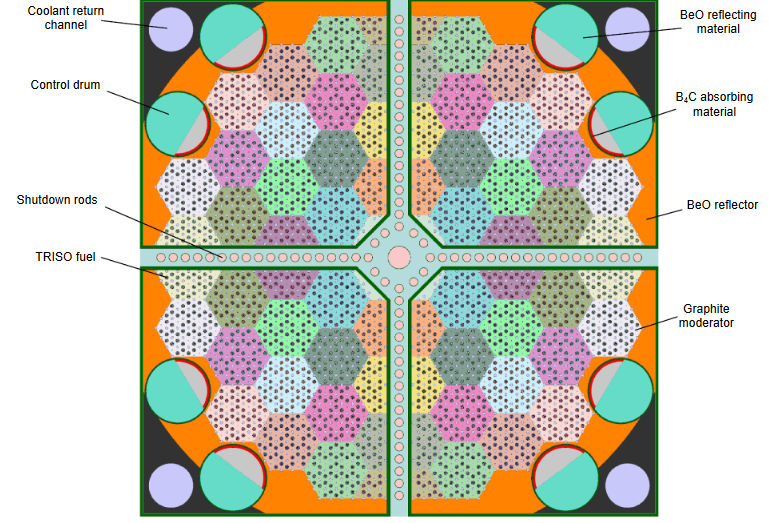

In [1]:
# Importing Packages
import time
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import Normalizer, MinMaxScaler

# pyMAISE specific imports
import pyMAISE as mai
from pyMAISE.datasets import load_HTGR
from pyMAISE.preprocessing import scale_data, train_test_split, correlation_matrix

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

## Training ML Models on the Raw Data (751 Samples)

Before applying symmetry to boost the samples, we evaluate the performance of several ML models on the original data set.

### Preprocessing

We define a regression problem and load the data using `pyMAISE.datasets.load_HTGR`.

In [2]:
# Initializing pyMAISE settings
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)

# Get data
data, inputs, outputs = load_HTGR()

The data consists of 751 samples with 8 inputs:

In [3]:
inputs

<xarray.DataArray (index: 751, variable: 8)>
array([[5.91952603, 2.36950271, 2.92365595, ..., 4.00890489, 4.97036758,
        2.98796636],
       [2.16238049, 0.273624302, 0.927740883, ..., 0.170166579,
        2.12404792, 4.98020926],
       [0.450100101, 0.006300644, 2.51221749, ..., 3.58225182,
        0.280763918, 4.88859544],
       ...,
       [5.96700387, 5.38006724, 5.20081594, ..., 5.65905406, 5.88623681,
        1.86231118],
       [1.34959071, 1.19391098, 4.65205108, ..., 3.19313598, 5.31477415,
        3.84849236],
       [3.60605462, 5.47085601, 1.75207802, ..., 5.07434654, 2.41128238,
        5.64650044]], dtype=object)
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 743 744 745 746 747 748 749 750
  * variable  (variable) object 'theta1' 'theta2' 'theta3' ... 'theta7' 'theta8'

and 4 outputs:

In [4]:
outputs

<xarray.DataArray (index: 751, variable: 4)>
array([[2.58e+19, 2.59e+19, 2.67e+19, 2.56e+19],
       [2.55e+19, 2.53e+19, 2.51e+19, 2.51e+19],
       [2.57e+19, 2.58e+19, 2.52e+19, 2.52e+19],
       ...,
       [2.57e+19, 2.53e+19, 2.52e+19, 2.57e+19],
       [2.64e+19, 2.52e+19, 2.59e+19, 2.61e+19],
       [2.51e+19, 2.55e+19, 2.61e+19, 2.55e+19]], dtype=object)
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 743 744 745 746 747 748 749 750
  * variable  (variable) object 'fluxQ1' 'fluxQ2' 'fluxQ3' 'fluxQ4'

Below is the correlation for this data set.

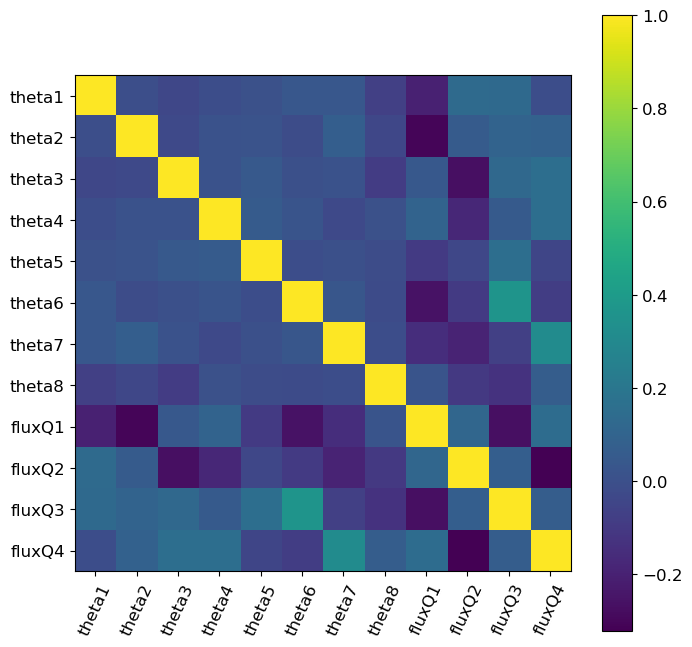

In [5]:
correlation_matrix(data)
plt.show()

We see there are no noticeable linear correlations between the inputs and outputs. There are some slightly positive correlations for `theta6` with `fluxQ3` and `theta7` with `fluxQ4`.

We train/test split the data (70%/30%) and scale the inputs and outputs. The inputs are min-max scaled, and the outputs are normalized across each sample.

In [6]:
# Train test split data
train_data, test_data = train_test_split(data=data, test_size=0.30)

theta_cols = [f"theta{i + 1}" for i in range(8)]
flux_cols = [f"fluxQ{i + 1}" for i in range(4)]

# Min-max scaling inputs and normalize and min-max scale outputs
xtrain, xtest, _ = scale_data(train_data.loc[:, theta_cols], test_data.loc[:, theta_cols], MinMaxScaler())
ytrain, ytest, _ = scale_data(train_data.loc[:, flux_cols], test_data.loc[:, flux_cols], Normalizer(norm="l1"))

### Model Initialization

We initialize six regression models:

- Linear: `Linear`,
- Lasso: `Lasso`,
- Decision tree: `DT`,
- Random forest: `RF`,
- K-nearest neighbors: `KN`,
- Feedforward dense neural: `FNN`.

All the classical models are initialized as Scikit-learn defaults. The FNN features a dense hidden network with three sections: input, hidden, and output. We hyperparameter tune the number of hidden layers and the number of nodes and sublayers for both the input and dense layers. We also tune the learning rate of the Adam optimizer and the batch size. We set epochs to 50 but will increase this after hyperparameter tuning.

In [7]:
# Initializing classical models and define hyperparameter search space for FNN
model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=2),
                "units": mai.Int(min_value=25, max_value=400),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.2, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
# Construct pyMAISE.Tuner object
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

### Hyperparameter Tuning

Below we define the search spaces for all the classical models except linear regression. For linear regression, we will use only the Scikit-learn default configuration. We utilize a random search with 200 iterations and 5-fold cross-validation, given their training speed. Given that the FNNs are more computationally expensive to train, we use a Bayesian search with 50 iterations, each with 5-fold cross-validation. We hope to converge on a performant model based on the Bayesian search.

In [8]:
# Classical model search space
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}

start = time.time()

# Run classical model random search
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=200,
    n_jobs=6,
    cv=5,
)

# Run FNN Bayesian search
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Hyperparameter tuning took 146.94733814398447 minutes to process.


We can visualize the hyperparameter tuning with Bayesian search of the FNN from the convergence plot below.

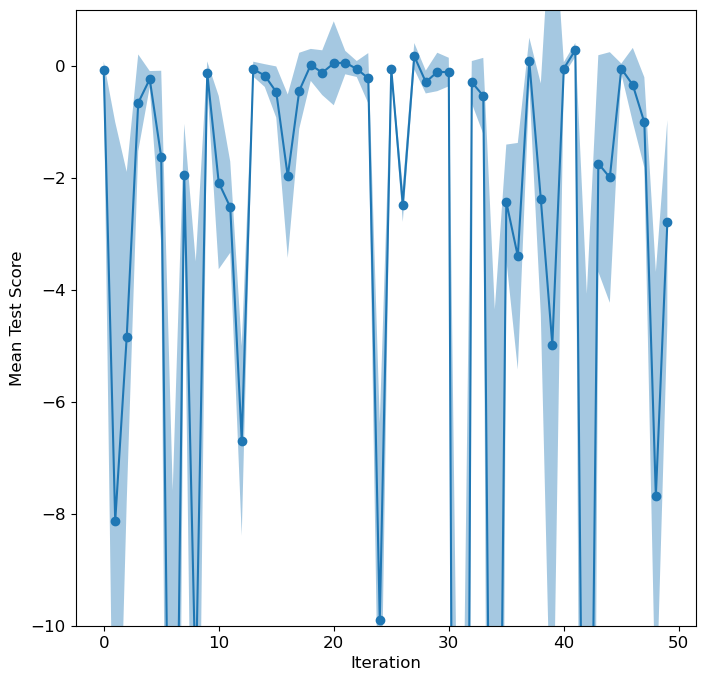

In [9]:
fig, ax = plt.subplots()
ax.set_ylim([-10, 1])
ax = tuner.convergence_plot(model_types="FNN")
plt.show()

The Bayesian search finds several configurations close to 0.4 validation $R^2$.

### Model Postprocessing

With the top 5 configurations saved, we can pass these to the `pyMAISE.PostProcessor` for model comparison and analysis. For the FNNs, we increase the epochs to 300 for better performance.

In [10]:
new_model_settings = {"FNN": {"fitting_params": {"epochs": 300}}}

postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest),
    model_configs=[random_search_configs, bayesian_search_configs],
    new_model_settings=new_model_settings,
)

Below we computed the performance metrics based on the performance of each model on all quadrants.

In [11]:
postprocessor.metrics().drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
25,FNN,0.933308,0.000841,0.336610,0.001062,0.423927,0.903581,0.001093,0.437491,0.001377,0.548052
24,FNN,0.863405,0.001205,0.481839,0.001517,0.600607,0.747785,0.001777,0.710116,0.002221,0.884590
23,FNN,0.921306,0.000825,0.330146,0.001150,0.458418,0.717868,0.001857,0.742270,0.002344,0.932931
21,FNN,0.764312,0.001627,0.651151,0.001987,0.753789,0.682033,0.002013,0.804986,0.002478,0.971878
22,FNN,0.827955,0.001340,0.535779,0.001707,0.678762,0.651750,0.002092,0.836222,0.002610,1.041642
12,RF,0.883306,0.001108,0.442423,0.001402,0.558431,0.580019,0.002269,0.905101,0.002855,1.132595
18,KN,1.000000,0.000000,0.000000,0.000000,0.000000,0.575674,0.002269,0.904600,0.002879,1.141598
17,KN,1.000000,0.000000,0.000000,0.000000,0.000000,0.575674,0.002269,0.904600,0.002879,1.141598
11,RF,0.897542,0.001035,0.413448,0.001314,0.523287,0.574769,0.002301,0.918016,0.002874,1.140428
16,KN,1.000000,0.000000,0.000000,0.000000,0.000000,0.571319,0.002292,0.913966,0.002894,1.148140


While the most performant models are the FNNs, all models performed poorly on this data set. Most models were overfit, with the FNNs offering the best performance. Below are the hyperparameter configurations.

In [12]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    postprocessor.print_model(model_type=model)
    print()

Model Type: Lasso
  alpha: 0.00010150661570965394

Model Type: DT
  max_depth: 10
  max_features: 4
  min_samples_leaf: 9
  min_samples_split: 14

Model Type: RF
  criterion: poisson
  max_features: 6
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 178

Model Type: KN
  leaf_size: 10
  n_neighbors: 9
  p: 1
  weights: distance

Model Type: FNN
  Structural Hyperparameters
    Layer: Dense_hidden_0
      units: 275
      sublayer: None
    Layer: Dense_output_0
  Compile/Fitting Hyperparameters
    Adam_learning_rate: 0.0006987490581536015
    batch_size: 8
Model: "FNN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 Dense_hidden_0 (Dense)      (None, 275)               2475      


 Dense_output_0 (Dense)      (None, 4)                 1104      


Total params: 3,579


Trainable params: 3,579


Non-trainable params: 0


_________________________________________________________________


Below is the network plot for the FNN.

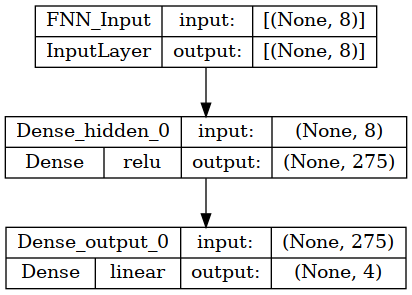

In [13]:
postprocessor.nn_network_plot(
    to_file="./supporting/HTGR_microreactor_network_0.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True,
)

To visualize the performance of these models we can use diagonal validation and validation plots as shown below.

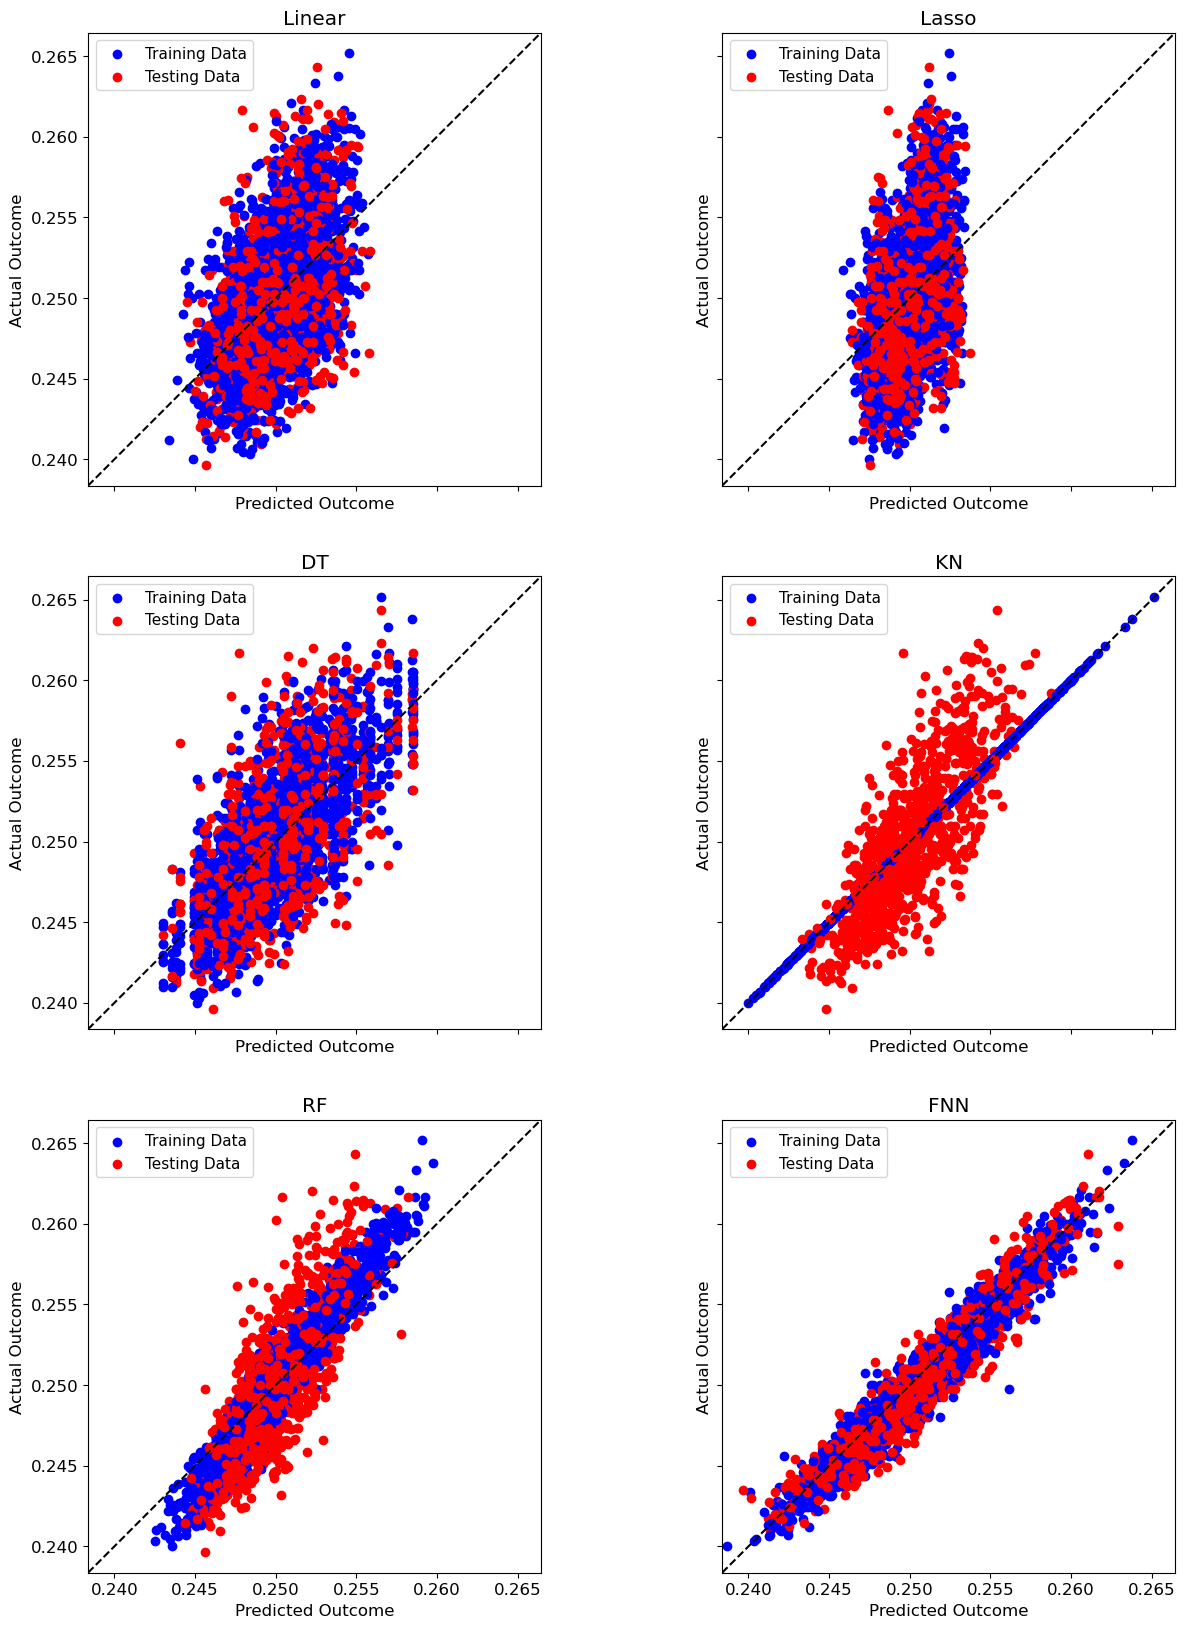

In [14]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
fig, axarr = plt.subplots(models.shape[0], models.shape[1], sharex=True, sharey=True, figsize=(15,20))
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.diagonal_validation_plot(model_type=models[i, j])
        axarr[i, j].set_title(models[i, j])

plt.show()

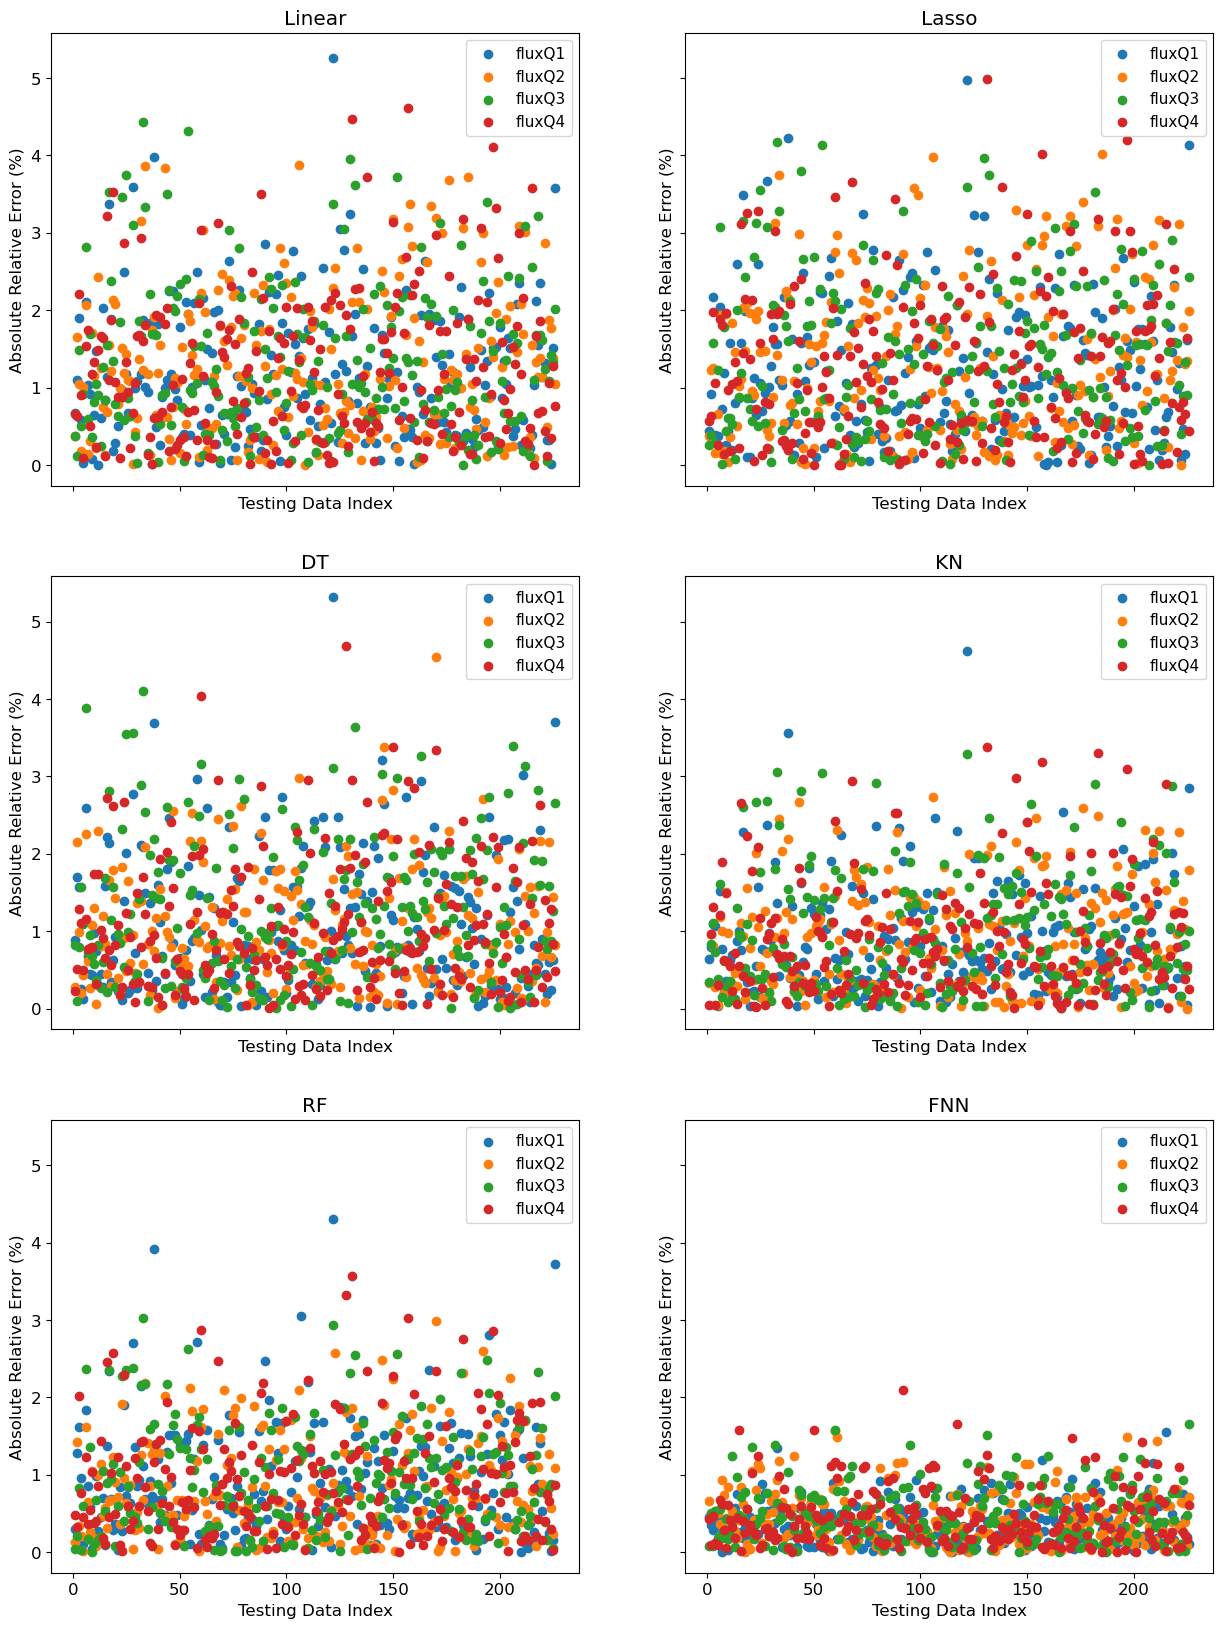

In [15]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
fig, axarr = plt.subplots(models.shape[0], models.shape[1], sharex=True, sharey=True, figsize=(15,20))
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.validation_plot(model_type=models[i, j])
        axarr[i, j].set_title(models[i, j])

plt.show()

The diagonal validation and validation plots agree with the conclusions gathered from the performance metrics. Each model overfit the training data, and none offers good performance. Below is the learning curve for the best-performing FNN, according to test $R^2$.

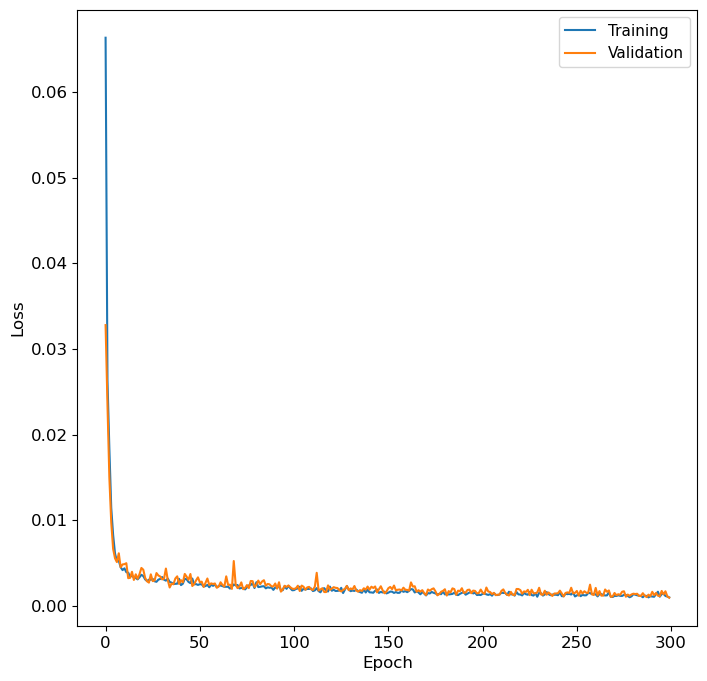

In [16]:
fig, ax = plt.subplots()
ax = postprocessor.nn_learning_plot()

plt.show()

The top-performing FNN does not overfit the training data, as shown by the overlapping of the training and validation loss curves.

## Increasing Samples Using Reactor Symmetry (3004 Samples)

We need more data to achieve better results. As shown in [[PRK22]](https://pymaise.readthedocs.io/en/stable/index.html#id9), we can apply symmetry rules to multiply the sample size.  

### Preprocessing

To multiply our samples, we use the `mult_sym` and `g21` functions from https://github.com/deanrp2/MicroControl/blob/main/pmdata/utils.py. These functions apply reflections over quadrant symmetries to multiply our samples by $4\times$. These functions have been reimplemented and simplified in `mult_samples` using the Xarray data structures pyMAISE uses. Additionally, rather than moving the drum range to $[-\pi, \pi]$, we leave it at $[0, 2\pi]$ to keep consistent with the previous section.

In [17]:
# Credit to mult_sym and g21 from https://github.com/deanrp2/MicroControl/blob/main/pmdata/utils.py#L51
def mult_samples(data):
    # Create empty arrays
    ht = xr.DataArray(
        np.zeros(data.shape), 
        coords={
            "index": [f"{idx}_h" for idx in data.coords["index"].values],
            "variable": data.coords["variable"],
        },
    )
    vt = xr.DataArray(
        np.zeros(data.shape), 
        coords={
            "index": [f"{idx}_v" for idx in data.coords["index"].values],
            "variable": data.coords["variable"],
        },
    )
    rt = xr.DataArray(
        np.zeros(data.shape),     
        coords={
            "index": [f"{idx}_r" for idx in data.coords["index"].values],
            "variable": data.coords["variable"],
        },
    )

    # Swap drum positions
    hkey = [f"theta{i}" for i in np.array([3, 2, 1, 0, 7, 6, 5, 4], dtype=int) + 1]
    vkey = [f"theta{i}" for i in np.array([7, 6, 5, 4, 3, 2, 1, 0], dtype=int) + 1]
    rkey = [f"theta{i}" for i in np.array([4, 5, 6, 7, 0, 1, 2, 3], dtype=int) + 1]

    ht.loc[:, hkey] = data.loc[:, theta_cols].values
    vt.loc[:, vkey] = data.loc[:, theta_cols].values
    rt.loc[:, rkey] = data.loc[:, theta_cols].values

    # Adjust angles
    ht.loc[:, hkey] = (3 * np.pi - ht.loc[:, hkey].loc[:, hkey]) % (2 * np.pi)
    vt.loc[:, vkey] = (2 * np.pi - vt.loc[:, hkey].loc[:, vkey]) % (2 * np.pi)
    rt.loc[:, rkey] = (np.pi + rt.loc[:, hkey].loc[:, rkey]) % (2 * np.pi)

    # Fill quadrant tallies
    hkey = [2, 1, 4, 3]
    vkey = [4, 3, 2, 1]
    rkey = [3, 4, 1, 2]

    ht.loc[:, [f"fluxQ{i}" for i in hkey]] = data.loc[:, flux_cols].values
    vt.loc[:, [f"fluxQ{i}" for i in vkey]] = data.loc[:, flux_cols].values
    rt.loc[:, [f"fluxQ{i}" for i in rkey]] = data.loc[:, flux_cols].values

    sym_data = xr.concat([data, ht, vt, rt], dim="index").sortby("index")
    
    # Normalize fluxes
    sym_data.loc[:, flux_cols].values = Normalizer().transform(sym_data.loc[:, flux_cols].values)
    
    # Convert global coordinate system to local
    loc_offsets = np.array(
        [3.6820187359906447, 4.067668586955522, 2.2155167202240653 - np.pi, 2.6011665711889425 - np.pi, 
         0.5404260824008517, 0.9260759333657285, 5.3571093738138575 - np.pi, 5.742759224778734 - np.pi]
    )

    # Apply correct 0 point
    sym_data.loc[:, theta_cols] = sym_data.loc[:, theta_cols] - loc_offsets + 2 * np.pi

    # Reverse necessary angles
    sym_data.loc[:, [f"theta{i}" for i in [3,4,5,6]]] *= -1

    # Scale all to [0, 2 * np.pi]
    sym_data.loc[:, theta_cols] = sym_data.loc[:, theta_cols] % (2 * np.pi)
        
    return sym_data

Rather than using the `careful_split` function in https://github.com/deanrp2/MicroControl/blob/main/pmdata/utils.py, we apply `mult_samples` to the training and testing data split, `train_data` and `test_data`, in the previous section. This ensures that reflected samples are in the same split as their original sample and keeps the split consistent across sections.

In [18]:
sym_train_data = mult_samples(train_data)
sym_test_data = mult_samples(test_data)
print(f"Multiplied training shape: {sym_train_data.shape}, Multiplied testing shape: {sym_test_data.shape}")

Multiplied training shape: (2100, 12), Multiplied testing shape: (904, 12)


We see our total samples increased from 751 to 3004.

Consistent with [[PRK22]](https://pymaise.readthedocs.io/en/stable/index.html#id9) and the previous section, we normalize the fluxes for each sample. Additionally, we min-max the inputs.

In [19]:
# Min-Max scaling data 
xtrain, xtest, _ = scale_data(sym_train_data.loc[:, theta_cols], sym_test_data.loc[:, theta_cols], MinMaxScaler())
ytrain, ytest, _ = scale_data(sym_train_data.loc[:, flux_cols], sym_test_data.loc[:, flux_cols], Normalizer(norm="l1"))

### Model Initialization and Hyperparameter Tuning

Here, we tune the models with the same hyperparameter search spaces defined in the previous section. We also use the same search methods with consistent iterations and cross-validation.

In [20]:
# Initialize pyMAISE.Tuner
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

start = time.time()

# Run classical model random search
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=200,
    n_jobs=6,
    cv=5,
)

# Run FNN Bayesian search
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Hyperparameter tuning took 731.8870798110962 minutes to process.


Once again we can show the convergence of Bayesian search.

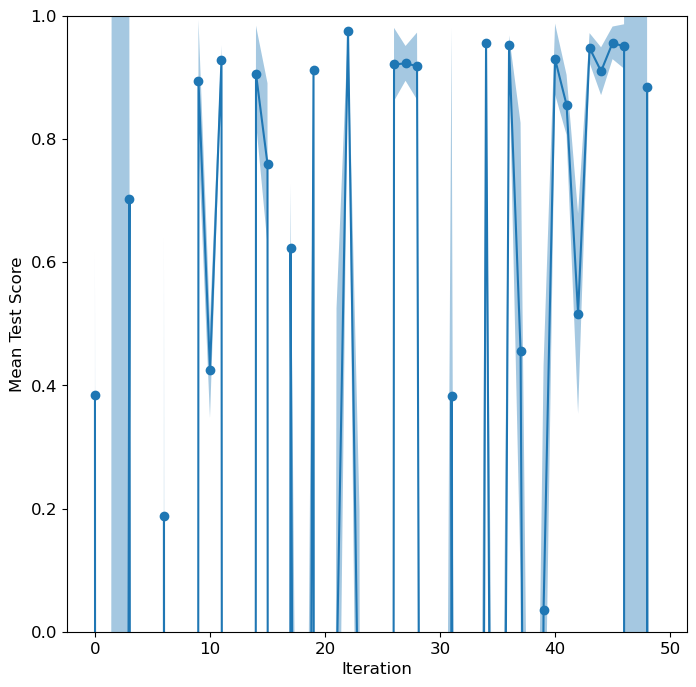

In [21]:
fig, ax = plt.subplots()
ax.set_ylim([0, 1])
ax = tuner.convergence_plot(model_types="FNN")
plt.show()

The Bayesian search provides FNN configurations that perform noticeable better than the FNNs tuned with 751 samples.

## Model Postprocessing

With the models tuned and the top 5 saved, we can now pass these models to the `pyMAISE.PostProcessor` for model comparison and analysis. Consistent with before we change the epochs of the FNNs to 300.

In [22]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest),
    model_configs=[random_search_configs, bayesian_search_configs],
    new_model_settings=new_model_settings,
)

The average performance metrics are shown below.

In [23]:
postprocessor.metrics().drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
21,FNN,9.842369e-01,0.000408,0.162995,0.000516,0.205895,9.790077e-01,0.000504,0.201551,0.000642,0.255792
25,FNN,9.728291e-01,0.000544,0.217470,0.000678,0.267080,9.735223e-01,0.000575,0.229799,0.000721,0.284036
22,FNN,9.663731e-01,0.000608,0.243188,0.000754,0.294476,9.687016e-01,0.000632,0.252438,0.000784,0.307272
24,FNN,9.545236e-01,0.000688,0.275426,0.000877,0.326627,9.570008e-01,0.000728,0.291176,0.000919,0.348954
23,FNN,9.488839e-01,0.000730,0.292070,0.000930,0.335942,9.500648e-01,0.000778,0.311449,0.000990,0.364471
18,KN,1.000000e+00,0.000000,0.000000,0.000000,0.000000,7.124542e-01,0.001859,0.741141,0.002376,0.941829
17,KN,1.000000e+00,0.000000,0.000000,0.000000,0.000000,7.124542e-01,0.001859,0.741141,0.002376,0.941829
16,KN,1.000000e+00,0.000000,0.000000,0.000000,0.000000,7.120861e-01,0.001861,0.741586,0.002377,0.942135
20,KN,1.000000e+00,0.000000,0.000000,0.000000,0.000000,7.080606e-01,0.001872,0.746109,0.002394,0.948781
19,KN,1.000000e+00,0.000000,0.000000,0.000000,0.000000,7.080606e-01,0.001872,0.746109,0.002394,0.948781


There is a significant performance increase in the FNNs, random forest models, and k-nearest neighbor models on the testing data set. All FNN models produce training and testing $R^2$ above 0.95, with the best above 0.973. The remaining models did not significantly improve performance from the increased sample size. All but the FNNs overfit to the training data set.

Below are the optimal hyperparameter configurations based on test $R^2$.

In [24]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    postprocessor.print_model(model_type=model)
    print()

Model Type: Lasso
  alpha: 0.006393301417873698

Model Type: DT
  max_depth: 39
  max_features: 6
  min_samples_leaf: 15
  min_samples_split: 5

Model Type: RF
  criterion: absolute_error
  max_features: None
  min_samples_leaf: 1
  min_samples_split: 3
  n_estimators: 75

Model Type: KN
  leaf_size: 11
  n_neighbors: 7
  p: 1
  weights: distance

Model Type: FNN
  Structural Hyperparameters
    Layer: Dense_hidden_0
      units: 115
      sublayer: None
    Layer: Dense_hidden_1
      units: 387
      sublayer: Dropout_hidden
    Layer: Dense_hidden_1_sublayer_Dropout_hidden_0
      rate: 0.26052385730556715
    Layer: Dense_output_0
  Compile/Fitting Hyperparameters
    Adam_learning_rate: 0.00018083202350898468
    batch_size: 8
Model: "FNN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 Dense_hidden_0 (Dense)      (None, 115)               1035      


 Dense_hidden_1 (Dense)      (None, 387)               44892     


 Dense_hidden_1_sublayer_Dro  (None, 387)              0         


 pout_hidden_0 (Dropout)                                         


 Dense_output_0 (Dense)      (None, 4)                 1552      


Total params: 47,479


Trainable params: 47,479


Non-trainable params: 0


_________________________________________________________________


Below is the network plot for the FNN.

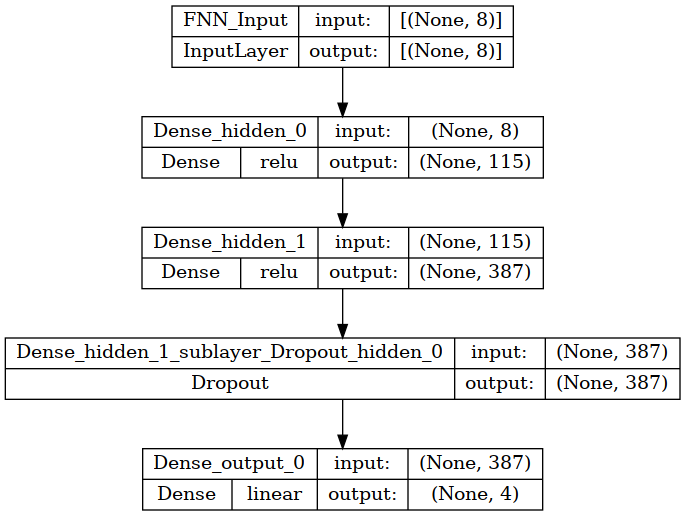

In [25]:
postprocessor.nn_network_plot(
    to_file="./supporting/HTGR_microreactor_network_1.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True,
)

Once again we can visualize the performance of the optimal models using diagonal validation and validation plots.

In [ ]:
def kan_equation(x1, x2, x3, x4, x5, x6, x7, x8):
    result = (
        -0.1292 * np.sin(5.5999 * x1 - 7.7952)
        - 0.122 * np.cos(5.6954 * x2 + 8.73)
        - 0.0549 * np.cos(6.174 * x7 + 0.9977)
        + 0.083 * np.cos(3.008 * x8 + 4.8941)
        + 0.5692
        + 0.0392 * np.exp(-40.96 * (0.7438 - x3) ** 2)
        - 0.1291 * np.exp(-16.0 * (0.669 - x6) ** 2)
        - 0.1698 * np.exp(-12.8451 * (0.5606 - x5) ** 2)
        - 0.1172 * np.exp(-13.256 * (0.4273 - x4) ** 2)
    )
    return result

In [ ]:
kan = kan_equation(xtest[:,0], xtest[:,1], xtest[:,2], xtest[:,3], xtest[:,4], xtest[:,5], xtest[:,6], xtest[:,7])
fig, ax = plt.subplots()
#ax = postprocessor.diagonal_validation_plot(model_type="FNN")
ax.scatter(kan, ytest, color='blue', label="KAN Testing Data")
model = postprocessor.get_model(model_type="FNN")
FNN_test = model.predict(xtest)[:,0]
ax.scatter(FNN_test, ytest, color='red', label="FNN Testing Data")
ax.plot(ytest, ytest, color='black')
ax.legend()
ax.set_xlabel('Predicted Scaled Neutron Flux in Q1')
ax.set_ylabel('True Scaled Neutron Flux in Q1')
plt.savefig('HTGR_KAN_validation.png', dpi=300)
plt.show()

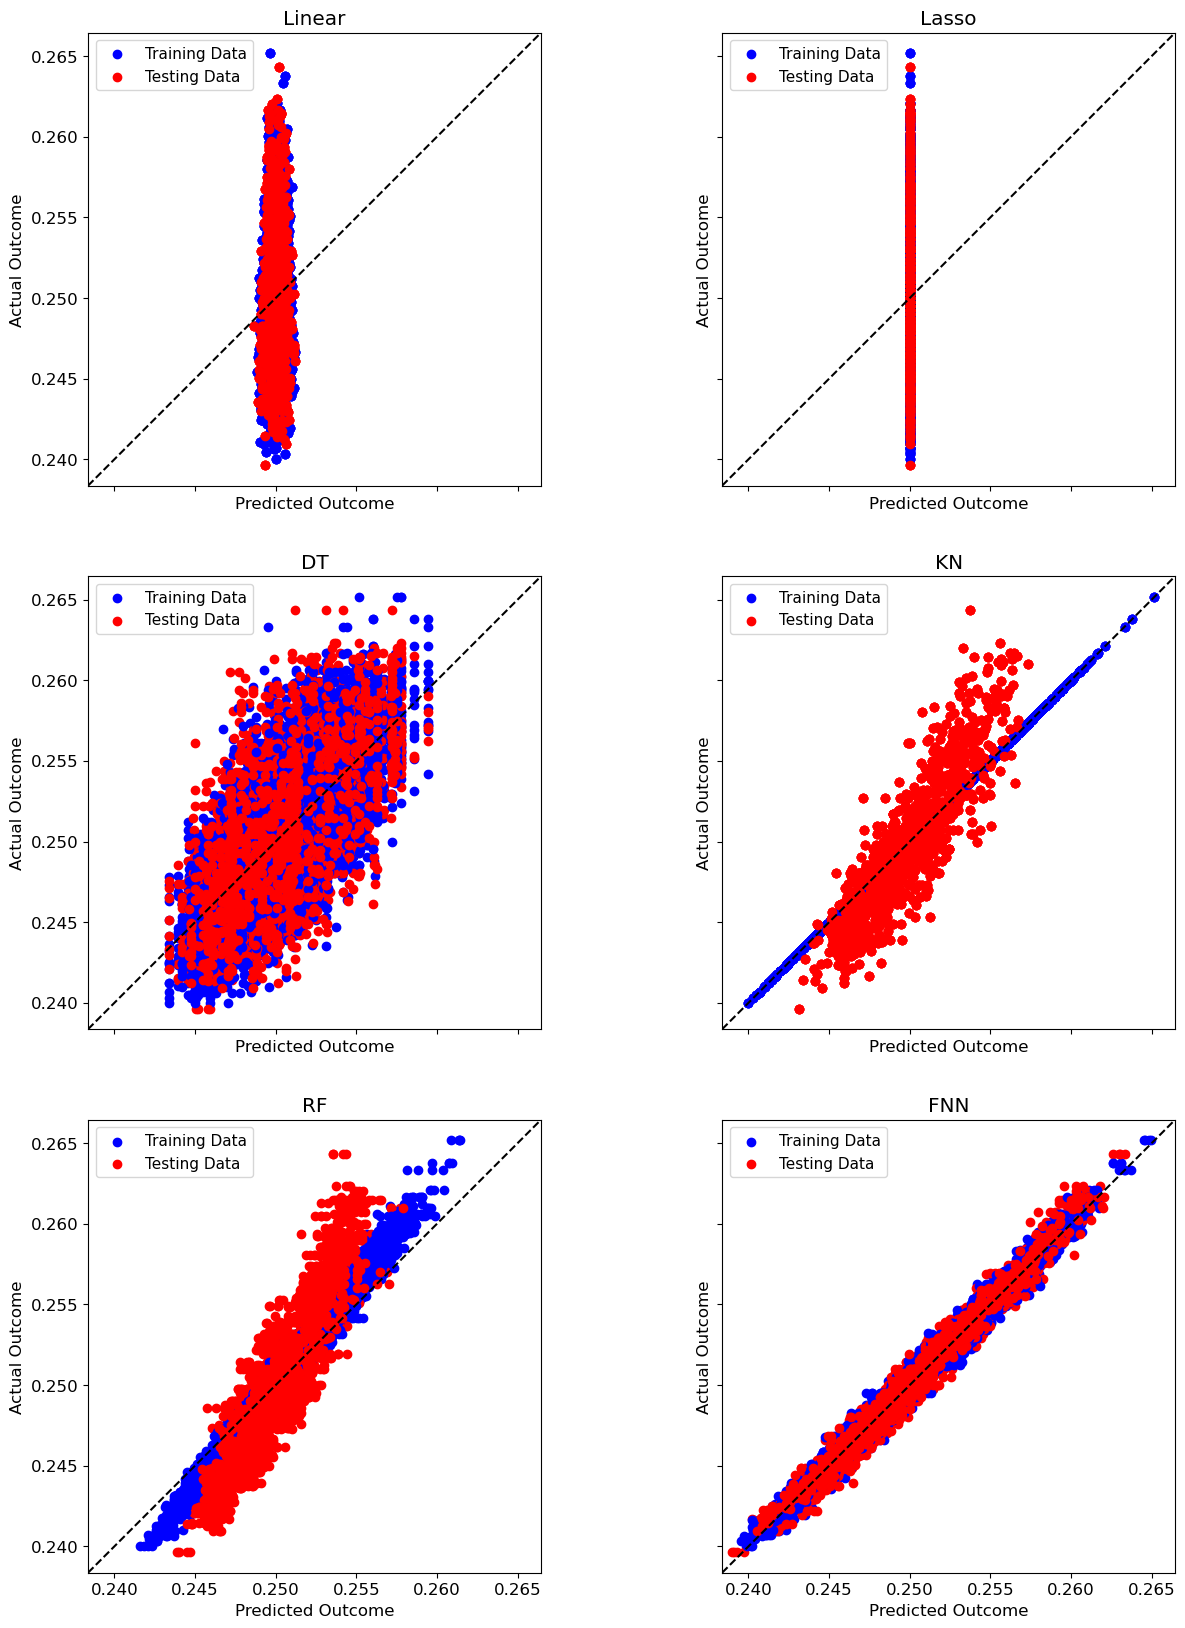

In [26]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
fig, axarr = plt.subplots(models.shape[0], models.shape[1], sharex=True, sharey=True, figsize=(15,20))
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.diagonal_validation_plot(model_type=models[i, j])
        axarr[i, j].set_title(models[i, j])

plt.show()

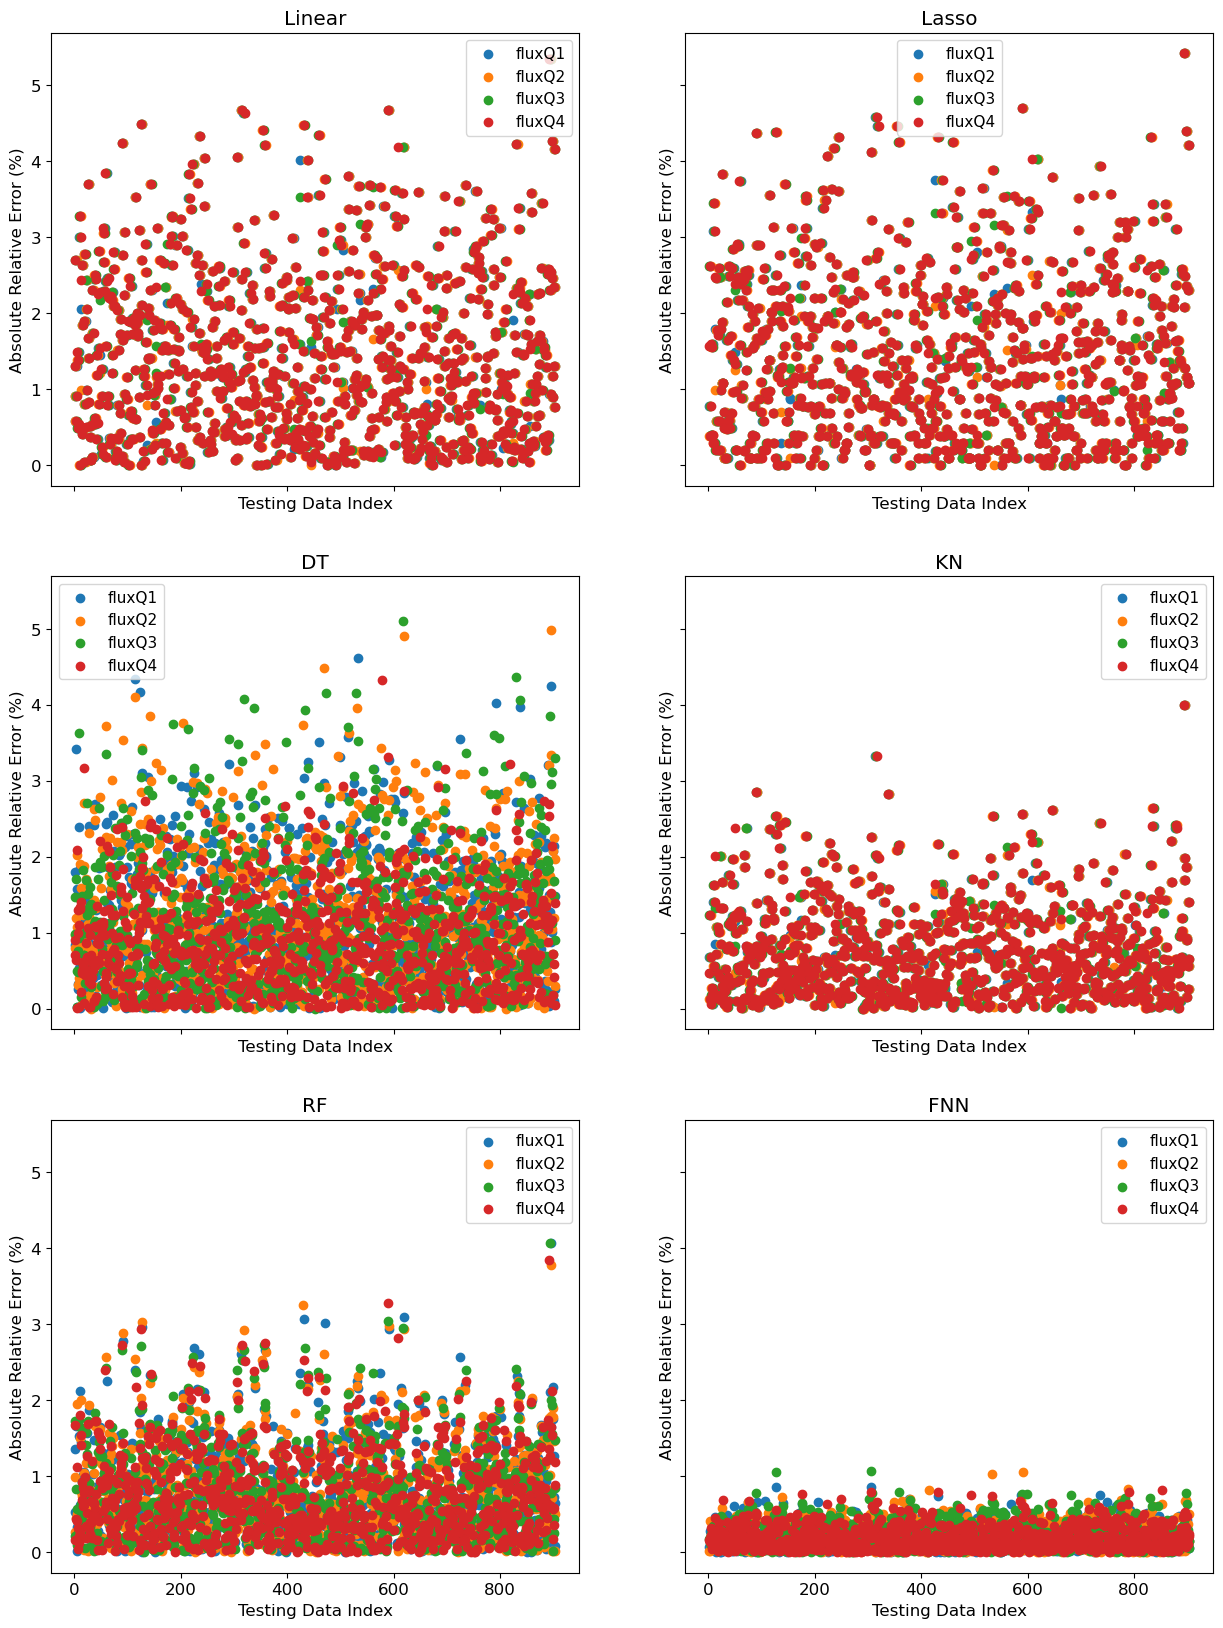

In [27]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
fig, axarr = plt.subplots(models.shape[0], models.shape[1], sharex=True, sharey=True, figsize=(15,20))
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.validation_plot(model_type=models[i, j])
        axarr[i, j].set_title(models[i, j])

plt.show()

Both plots reaffirm the conclusions from the performance metrics. The FNN model performs significantly better than the other models, with most test data predictions off by less than 1%. Below is the learning curve of the optimal FNN model. 

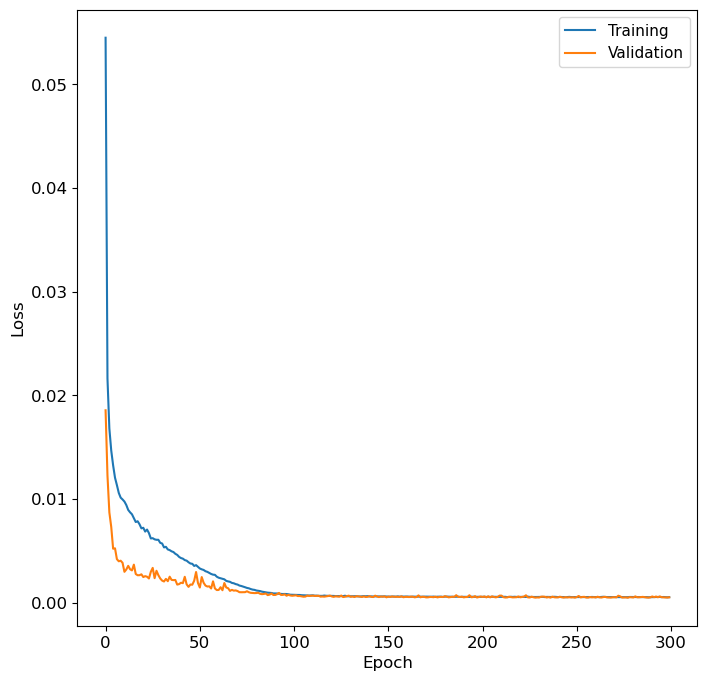

In [28]:
fig, ax = plt.subplots()
ax = postprocessor.nn_learning_plot()
plt.show()

/home/npanczyk/pyMAISE/pyMAISE/explain/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/home/npanczyk/miniconda3/envs/maise/lib/python3.11/site-packages/keras/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


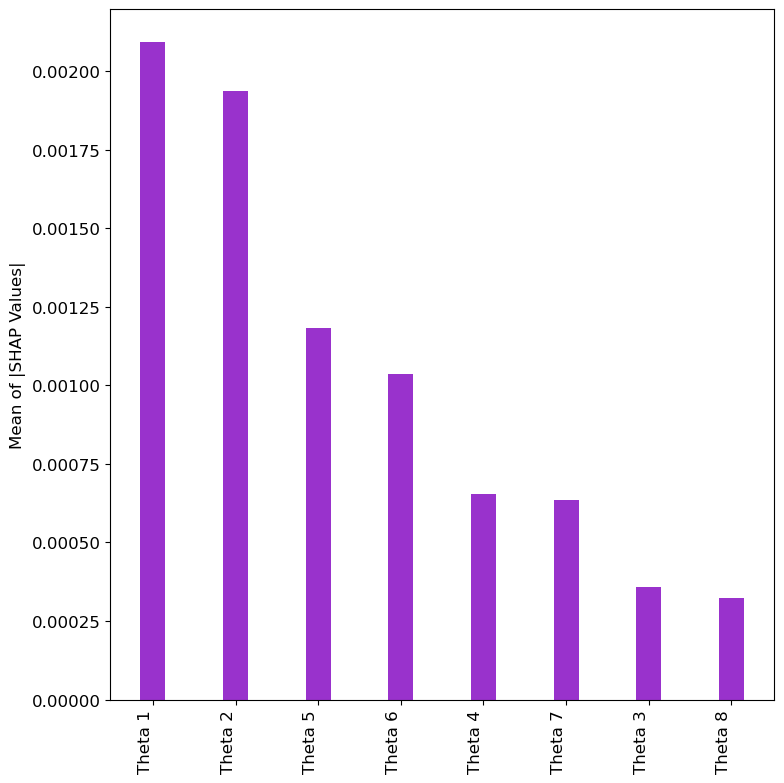

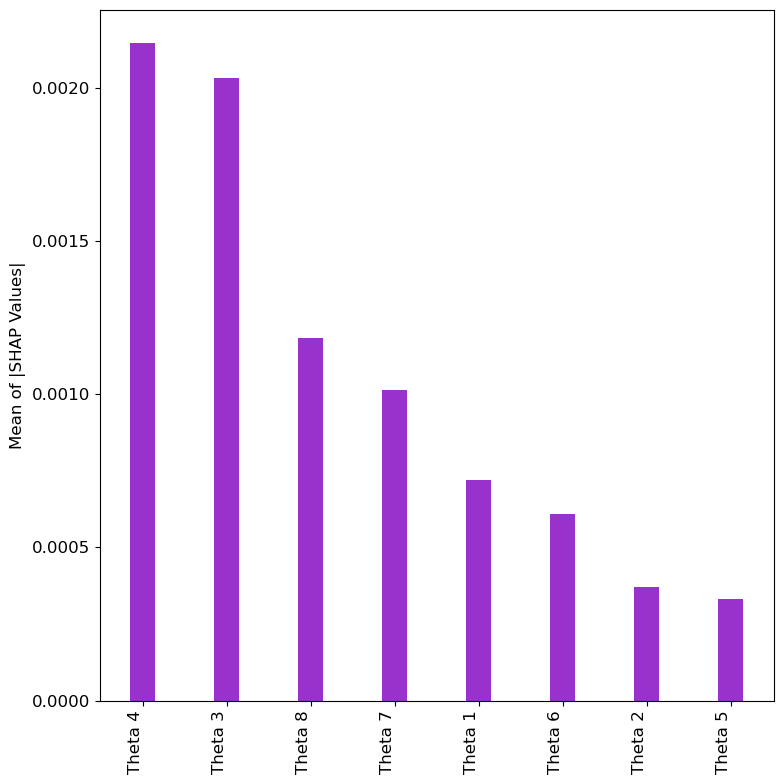

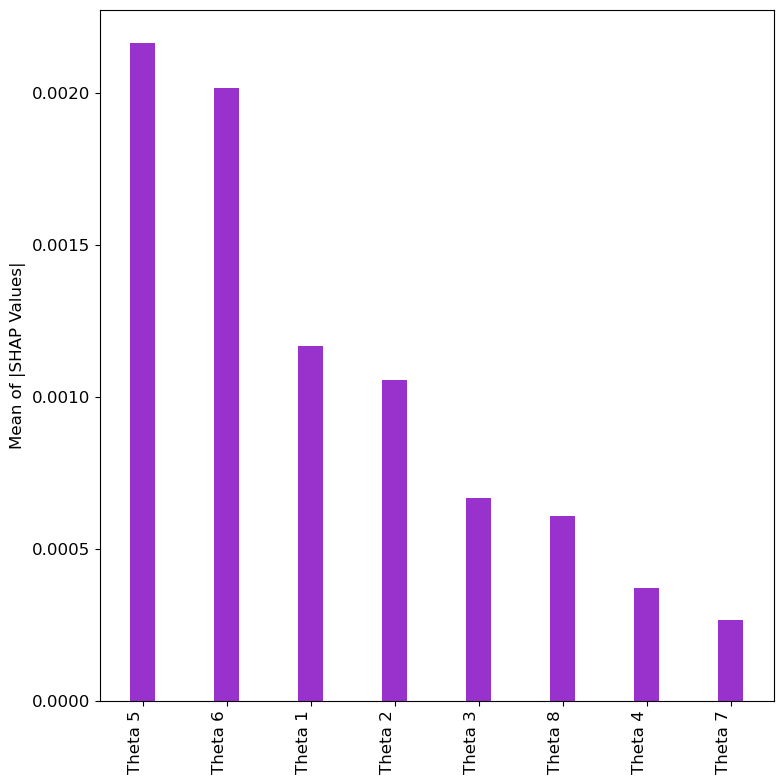

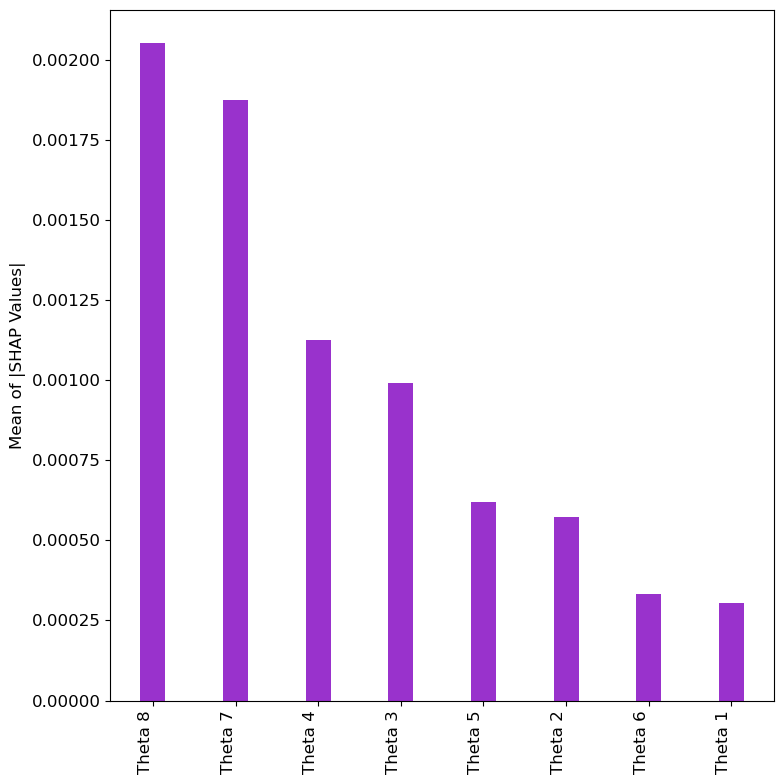

In [29]:
import pyMAISE.explain._explain as explain

model = postprocessor.get_model(model_type="FNN")

feature_names = ['Theta 1', 'Theta 2', 'Theta 3', 'Theta 4', 'Theta 5', 'Theta 6', 'Theta 7', 'Theta 8']
output_names = ['Flux Q1', 'Flux Q2', 'Flux Q3',
       'Flux Q4']

explainer = explain.ShapExplainers(model, X=xtest.values, 
                   feature_names=feature_names, 
                   output_names=output_names)
explainer.DeepLIFT(nsamples=None)
explainer.postprocess_results()
explainer.plot_bar_only(run_name='HTGR_kan_DL')

The validation loss curve is consistently below the training curve, indicating the FNN is not overfitting.

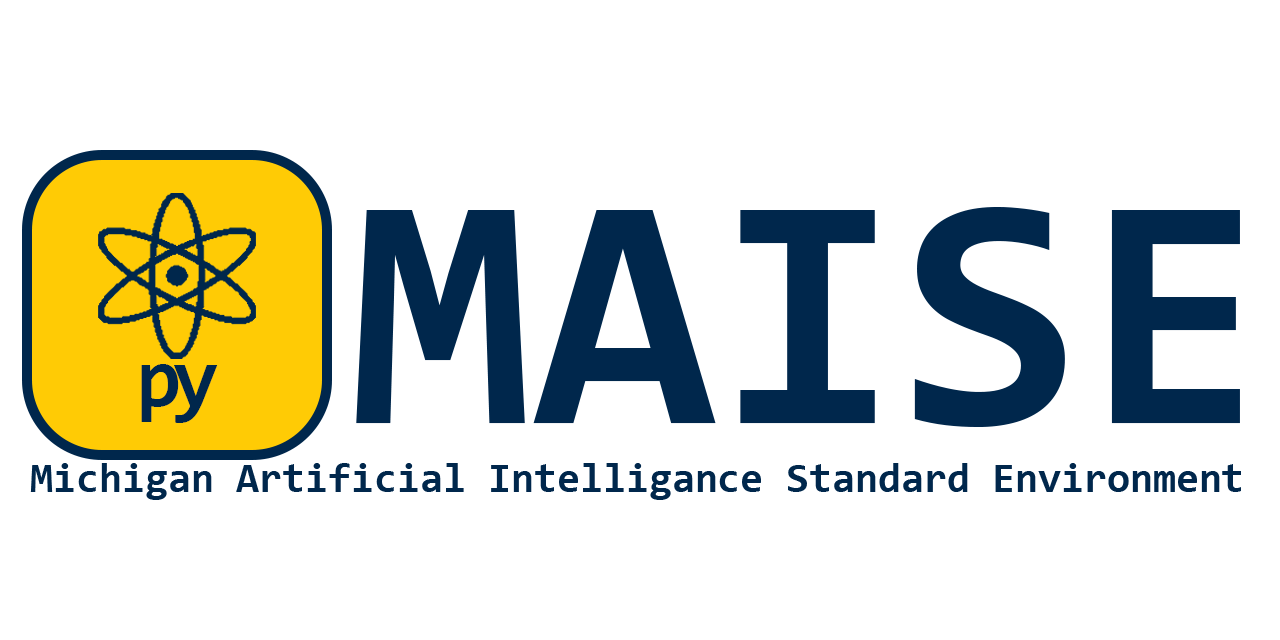